<a href="https://colab.research.google.com/github/tglik/computer_vision/blob/main/generative/text2image/stable_diffusion_prompt_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stable Diffusion prompt-controlled inpainting

In [1]:
!git clone https://github.com/timojl/clipseg

Cloning into 'clipseg'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 211 (delta 51), reused 42 (delta 42), pack-reused 145
Receiving objects: 100% (211/211), 1.40 MiB | 1.95 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [2]:
!pip install diffusers -q
!pip install transformers -q -UU ftfy gradio
!pip install git+https://github.com/openai/CLIP.git -q

     |████████████████████████████████| 524 kB 9.8 MB/s 
     |████████████████████████████████| 182 kB 80.5 MB/s 
     |████████████████████████████████| 5.8 MB 12.6 MB/s 
     |████████████████████████████████| 53 kB 1.5 MB/s 
     |████████████████████████████████| 13.8 MB 74.0 MB/s 
     |████████████████████████████████| 7.6 MB 67.5 MB/s 
     |████████████████████████████████| 106 kB 72.8 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
     |████████████████████████████████| 2.3 MB 18.6 MB/s 
     |████████████████████████████████| 56 kB 5.2 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
     |████████████████████████████████| 278 kB 75.2 MB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████████████████| 64 kB 3.6 MB/s 
     |████████████████████████████████| 80 kB 10.2 MB/s 
     |████████████████████████████████| 69 kB 8.8 MB/s 
     |████████████████████████████████| 58 kB 7.1 MB/s 
     |█████████████████████████

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [4]:
%cd clipseg

/content/clipseg


In [7]:
!ls

datasets	     metrics.py		      score.py
environment.yml      models		      setup.py
evaluation_utils.py  overview.png	      supplementary.pdf
example_image.jpg    Quickstart.ipynb	      Tables.ipynb
experiments	     README.md		      training.py
general_utils.py     sample_rd64.png	      Visual_Feature_Engineering.ipynb
LICENSE		     sample_rd64_refined.png


In [5]:
!wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
!unzip -d weights -j weights.zip

--2022-12-26 13:02:27--  https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘weights.zip’

weights.zip             [  <=>               ]   9.68M  1.24MB/s    in 14s     

2022-12-26 13:02:42 (712 KB/s) - ‘weights.zip’ saved [10146905]

Archive:  weights.zip
 extracting: weights/rd16-uni.pth    
 extracting: weights/rd64-uni-refined.pth  
 extracting: weights/rd64-uni.pth    


In [56]:
from torch.types import Device
import torch
import requests
import cv2 
from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
from io import BytesIO
from torch import autocast
import requests
import PIL
import torch
from diffusers import StableDiffusionInpaintPipeline
import numpy as np

device = 'cuda'
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();
model.load_state_dict(torch.load('/content/clipseg/weights/rd64-uni.pth', 
                                 map_location=torch.device(device)), strict=False)
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [72]:
input = Image.open('../Untitled.jpg')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.225, 0.225, 0.225]),
    transforms.Resize((512, 512))
])
img = transform(input).unsqueeze(0)

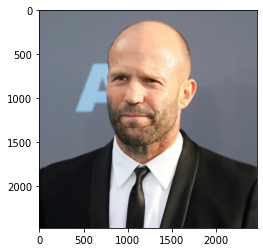

In [73]:
input.convert('RGB').resize((512, 512)).save('before.png', 'PNG')
plt.imshow(input)
plt.show()

[Text(0, -15, 'shirt and jacket')]

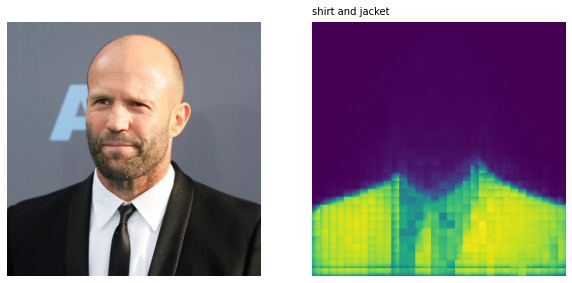

In [74]:
prompts = ['shirt and jacket']
with torch.no_grad():
  preds = model(img.repeat(len(prompts), 1, 1, 1), prompts)[0]

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(10, 5))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input)
[ax[i + 1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))]
[ax[i + 1].text(0, -15, prompts[i]) for i in range(len(prompts))]

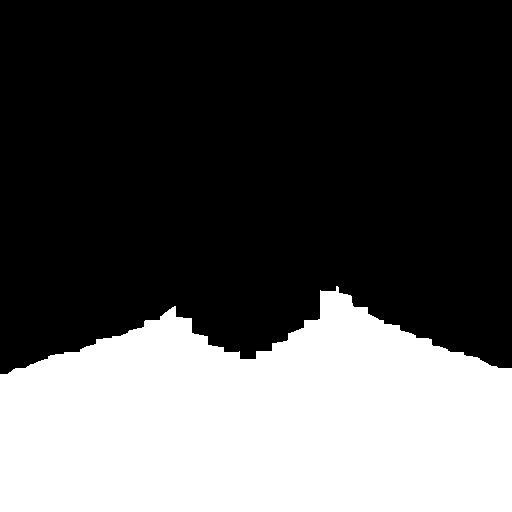

In [75]:
filename = 'mask.png'
plt.imsave(filename, torch.sigmoid(preds[0][0]))

img2 = cv2.imread(filename)
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
thresh, bw = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

kernel=np.ones((15,15),np.uint8)
bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

cv2.imwrite(filename, bw)
cv2.cvtColor(bw, cv2.COLOR_BGR2RGB)
Image.fromarray(bw)

In [104]:
init_img = Image.open('before.png')
mask = Image.open('mask.png')

with autocast(device):
  output = pipe(prompt='a man with colorful tie and red shirt', 
                init_image=init_img, mask_image=mask, strength=0.8)

  0%|          | 0/40 [00:00<?, ?it/s]

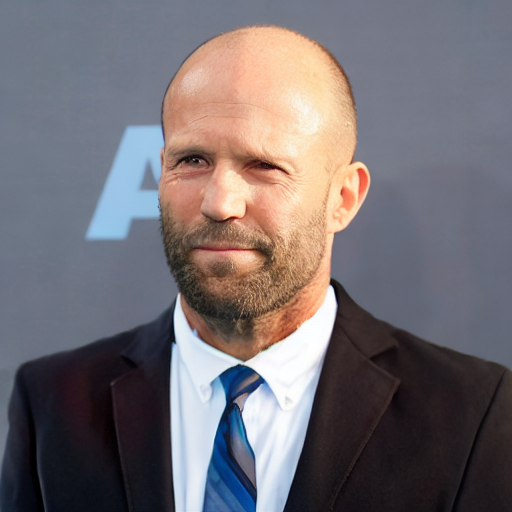

In [105]:
output.images[0]